# Réseau FC

### Préparation du Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

# Lister les fichiers et dossiers à la racine de "MyDrive"
os.listdir('/content/drive/MyDrive/Colab Notebooks')

['data_processed.zip',
 'Untitled0.ipynb',
 'CNN.ipynb',
 'FC.ipynb',
 'Elliot feur']

In [ ]:
source = '/content/drive/MyDrive/Colab Notebooks/data_processed.zip'
dest   = '/content/'

!cp "$source" "$dest"

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
!unzip -q data_processed.zip
!ls

Commencons par installer keras

In [ ]:
# Install Keras 3 on colabs
!pip install -q keras-nightly

import os
import numpy as np
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "torch"
import keras

print("Keras version:",keras.__version__)

In [ ]:
print("CPU info:")
!lscpu |grep 'Model name'

In [ ]:
import shutil
import random
from sklearn.model_selection import train_test_split

# Répertoires des catégories d'images
categories = ['cars', 'locomotives', 'airplanes', 'bicycles', 'trucks', 'tractors', 'boats']
data_dir = '/content/data_processed'  # Répertoire contenant les sous-dossiers de catégories

# Créer les répertoires train, validation, test
base_dir = '/content/data_processed_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Créer des sous-dossiers pour chaque catégorie dans train, validation et test
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# Séparer les images en ensembles train, validation et test
for category in categories:
    category_dir = os.path.join(data_dir, category)
    all_images = os.listdir(category_dir)

    # Diviser les images en train, validation, test (70%, 20%, 10%)
    train_images, temp_images = train_test_split(all_images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.333, random_state=42)  # 0.333 pour avoir 10% du total pour test

    # Déplacer les images dans les bons répertoires
    for img in train_images:
        shutil.copy(os.path.join(category_dir, img), os.path.join(train_dir, category, img))
    for img in val_images:
        shutil.copy(os.path.join(category_dir, img), os.path.join(val_dir, category, img))
    for img in test_images:
        shutil.copy(os.path.join(category_dir, img), os.path.join(test_dir, category, img))

print(f"Répertoires créés et images séparées avec succès.")


Répertoires créés et images séparées avec succès.


Chargeons les images depuis data_processed et créeons nos sets

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paramètres
img_height, img_width = 224, 224  # Taille des images (224x224x3)
batch_size = 32
num_classes = len(categories)

# Création d'un générateur d'images avec augmentation des données
datagen = ImageDataGenerator(
    rescale=1./255,      # Normalisation des images (0 à 1)
    rotation_range=20,   # Rotation des images
    width_shift_range=0.2,  # Déplacement horizontal
    height_shift_range=0.2,  # Déplacement vertical
    shear_range=0.2,     # Cisaillement
    zoom_range=0.2,      # Zoom
    horizontal_flip=True,  # Retourner les images horizontalement
    fill_mode='nearest'   # Remplir les pixels manquants
)

# Flux de données d'entraînement, validation et test
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),  # Redimensionner les images
    batch_size=batch_size,
    class_mode='categorical',  # Type de label (catégorique)
)

validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Normalisation uniquement pour les données de test
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

# Afficher le nombre d'images dans chaque ensemble
print(f'Entraînement : {train_generator.samples} images, Validation : {validation_generator.samples} images, Test : {test_generator.samples} images')


Found 5939 images belonging to 7 classes.
Found 1699 images belonging to 7 classes.
Found 851 images belonging to 7 classes.
Entraînement : 5939 images, Validation : 1699 images, Test : 851 images


On visualise nos données pour vérifier que tout est bon

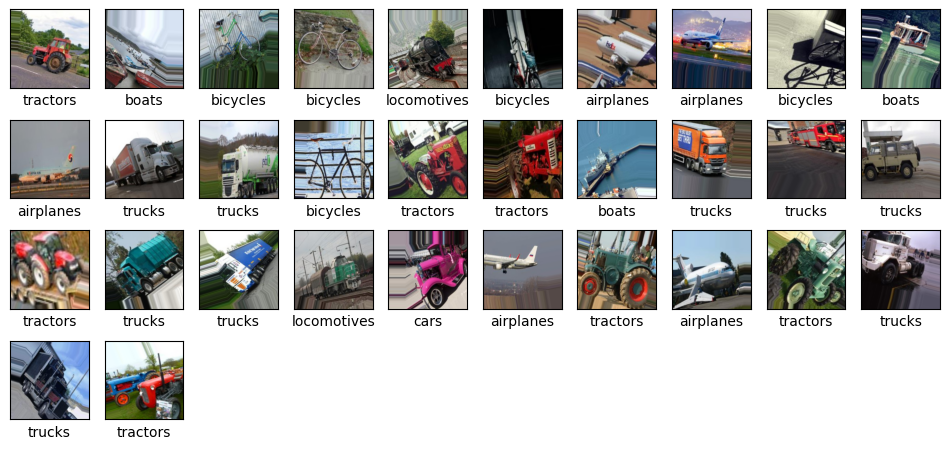

In [ ]:
import matplotlib.pyplot as plt

# Charger un batch d'images depuis le générateur
batch_size = 32
images_batch, labels_batch = next(train_generator)

# Calculer le nombre de lignes et de colonnes pour afficher les images
rows, cols = 5, 10  # 5 lignes et 10 colonnes (maximum 50 images)
plt.figure(figsize=(12, 6))
plt.subplots_adjust(top=1)

# Afficher les images
for i in range(min(batch_size, 50)):
    plt.subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_batch[i])
    class_names = list(train_generator.class_indices.keys())
    plt.xlabel(class_names[labels_batch[i].argmax()])

plt.show()


Créeons le Réseau FC

In [ ]:
import tensorflow as tf

# Création du modèle Fully Connected (FC)
model = tf.keras.models.Sequential()

# Première couche d'entrée (Flatten les images)
model.add(keras.layers.Flatten(input_shape=(224, 224, 3)))

# Couche cachée 1 : 512 neurones avec activation ReLU et Batch Normalization
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))  # Dropout pour éviter le surapprentissage

# Couche cachée 2 : 256 neurones avec activation ReLU et Batch Normalization
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

# Couche cachée 3 : 128 neurones avec activation ReLU et Batch Normalization
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

# Couche de sortie avec activation Softmax (7 classes)
model.add(keras.layers.Dense(7, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Nos images sont en couleurs et au format 224x224, nous indiquons donc la shape (224,224,3)


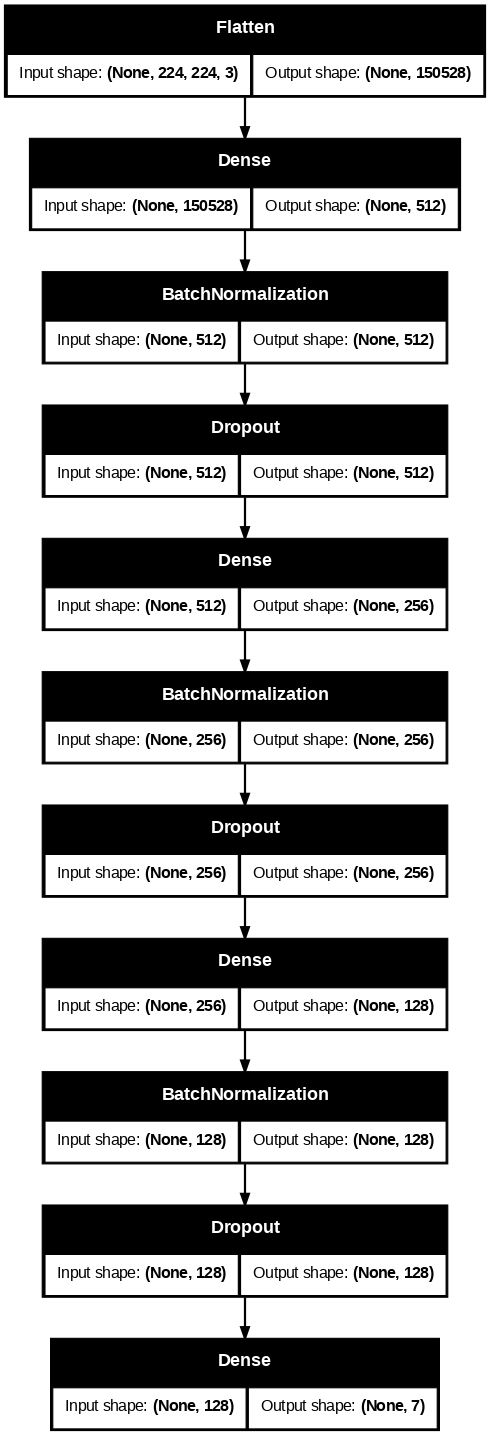

In [ ]:
keras.utils.plot_model(model,  dpi=80, show_shapes=True)

In [ ]:
model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Création du callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True)

In [1]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


NameError: name 'model' is not defined

In [ ]:
# Évaluation du modèle sur les données de test
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

print('\nTest accuracy:', test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 - 1s - 39ms/step - accuracy: 0.4042 - loss: 1.7543

Test accuracy: 0.4042303264141083
